In [57]:
# enables direct importing of .py files
from pandawrapper import PandaWrapper, read
from merge_auto import merge_auto

Versions

In [2]:
import version
version.control({"numpy","scipy","matplotlib","pandas","sklearn",
                 "joblib","tqdm","jupyter","xgboost","seaborn","xlrd","pip"})

python: 3.9.4 | packaged by conda-forge | (default, May 10 2021, 22:10:34) [MSC v.1916 64 bit (AMD64)]
pandas: 1.2.3
sklearn: 0.24.1
numpy: 1.19.2
matplotlib: 3.3.4
joblib: 1.0.1
seaborn: 0.11.1
jupyter has no __version__ attribute.
pip: 21.1.2
xlrd: 2.0.1
xgboost: 1.4.0
tqdm: 4.59.0
scipy: 1.6.2


In [59]:
import numpy as np

## Pre-trained model 1: SDF vs. PAXDB protein.

Inputs

In [3]:
X = read("../Data/sPCA_dg_mca.csv")

Consensus y target

    y = pd.read_table("Data/PAXDB-9606-WHOLE-CONSENSUS.txt", header=11)
    y['ensembl_prot_id'] = y['string_external_id'].str[5:]
    # preprocess y to log2 non parts per million.
    y['log2_abundance'] = y['abundance'].multiply(1000000).apply(np.log2).replace(-np.inf, np.nan)

In [4]:
y = read("../Data/PAXDB_WHOLE_CONSENSUS.csv")

Mappable HGNC labels

In [5]:
hgnc = read("../Data/hgnc_labels.csv")

<ipython-input-5-edd2a5d2f764>:1: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  hgnc = read("../Data/hgnc_labels.csv")


Merge and clean

In [6]:
intgr = merge_auto([hgnc, X, y], verbose=3)

intgr = PandaWrapper.wrap(intgr.drop_duplicates(subset=['ensembl_gene_id'])
     .dropna(subset=['log2_abundance']))

Merging hgnc_labels[504934,8] (`ensembl_gene_id`) | sPCA_dg_mca[15269,137] (`ensembl_id`) -> 14912/0.98 on columns
Merging df1[231063,145] (`ensembl_peptide_id`) | PAXDB_WHOLE_CONSENSUS[19949,3] (`ensembl_prot_id`) -> 14531/0.73 on columns


Fitting hyperparameters

In [10]:
import xgboost as xgb
from scipy import stats
from hyperfastcv import HyperFastCV
from sksupport import make_ml_ready, plot_parameter_tune
from cache import Reloader

from sklearn.model_selection import RepeatedKFold

In [8]:
cv_model = xgb.XGBRegressor()
xgb_params = {'learning_rate': stats.halfnorm(0.0001, 0.2),
              "alpha": stats.loguniform(1e-4, 1e-1),
              "lambda": stats.loguniform(1e-4, 1e-1)}

In [9]:
X_train, y_train = make_ml_ready(intgr, X.view("~id"), "log2_abundance", test_size=None)

WARNING: This takes a while.

In [12]:
with Reloader("../Data/_hyperparam_model1.pkl") as c:
    gscv = HyperFastCV(cv_model, xgb_params, n_trials=50, chunk=.2, cv=RepeatedKFold(n_splits=5, n_repeats=3))
    gscv = c(gscv.fit, X_train, y_train)

  0%|          | 0/50 [00:00<?, ?it/s]

running chunk '../Data/_hyperparam_model1.pkl'


100%|██████████| 50/50 [1:11:05<00:00, 85.30s/it]

writing file '../Data/_hyperparam_model1.pkl'


Plotting parameter choice output:

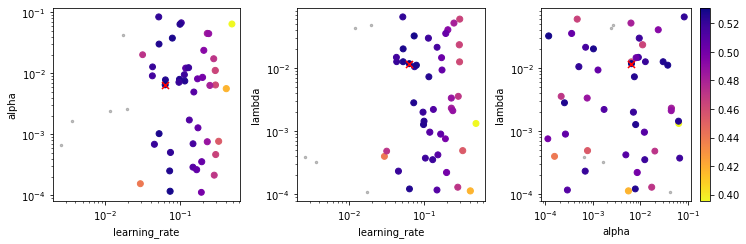

In [13]:
plot_parameter_tune(gscv)

Re-fitting best model and pickling

In [14]:
from joblib import dump, load

In [15]:
model = xgb.XGBRegressor(**gscv.best_params_)
model.fit(X_train, y_train)

XGBRegressor(alpha=0.006509436296402281, base_score=0.5, booster='gbtree',
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', lambda=0.011746575457472031,
             learning_rate=0.06266668202407553, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0.00650943629, reg_lambda=0.0117465751,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [359]:
dump(model, "../Models/xgb_basic.pkl")

['../Models/xgb_basic.pkl']

### Prepare meta-information to go alongside pre-trained model

We'll compute some cross-validated predictions of each given PAXDB protein as a comparison benchmark for future use.

In [34]:
from sklearn.model_selection import cross_val_predict
import pandas as pd

In [21]:
ypreds = cross_val_predict(model, X_train, y_train, cv=5)

In [43]:
ypred_series = pd.Series(ypreds, index=intgr['ensembl_peptide_id'])

#### Computing $R^2$ between predicted and actual

In [44]:
from sklearn.metrics import r2_score

In [53]:
y_true = intgr.set_index("ensembl_peptide_id")['log2_abundance']
r2_score(y_true, ypreds)

0.5670350187794435

#### Estimating residuals (distance in estimate for each protein).

In [383]:
meta = pd.DataFrame({
    "y_predict": ypred_series, "resid": y_true - ypred_series
})

meta.to_csv("../Data/xgb_basic_predictions.csv")

## Plotting Data

Here we generate a few interesting plots to display the relationship between measured protein abundance and predicted.

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline

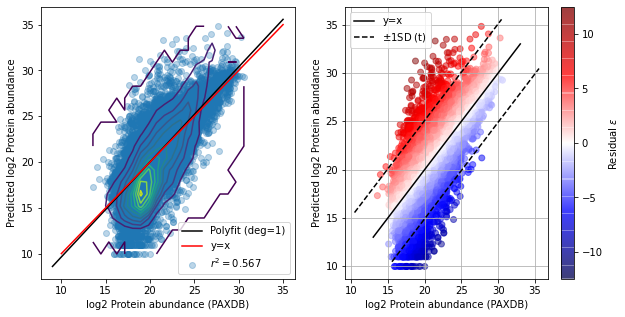

In [402]:
fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# plot 1

Nbins = 20
bins, edge1, edge2= np.histogram2d(ypred_series.values, y_true.values, bins=Nbins, density=True)
Xdir, Ydir = np.meshgrid(np.linspace(ypreds.min(), ypreds.max(), Nbins), np.linspace(y_true.min(), y_true.max(), Nbins))

ax1.contour(Xdir, Ydir, bins, levels=10)

ax1.scatter(ypred_series, y_true, alpha=.3, 
            label=r"$r^2={:0.3f}$".format(r2_score(y_true, ypred_series)))
ax1.set_xlabel("log2 Protein abundance (PAXDB)")
ax1.set_ylabel("Predicted log2 Protein abundance")

xline = np.linspace(9, 35, 2)
yline = np.polyval(np.polyfit(ypred_series, y_true, 1), xline)
ax1.plot(xline, yline, color='k', label='Polyfit (deg=1)')
ax1.plot([10., 35.], [10., 35.], color='r', label='y=x')
ax1.legend()

# plot 2
from scipy import stats
t_std = stats.t(*t_params).std()
midx, midy = np.array([13., 33.]), np.array([13., 33.])
c_poss = max(abs(meta['resid'].min()), abs(meta['resid'].max()))

cax = ax2.scatter(ypred_series, y_true, c=meta['resid'], cmap="seismic", alpha=.5, vmin=-c_poss, vmax=c_poss)
ax2.plot(midx, midy, color='k', label='y=x')
ax2.plot(midx + t_std, midy - t_std, color='k', linestyle='--', label=r"$\pm$1SD (t)")
ax2.plot(midx - t_std, midy + t_std, color='k', linestyle='--')
ax2.legend()

fig.colorbar(cax).set_label(r"Residual $\epsilon$")
ax2.set_xlabel("log2 Protein abundance (PAXDB)")
ax2.set_ylabel("Predicted log2 Protein abundance")
plt.grid()

plt.show()



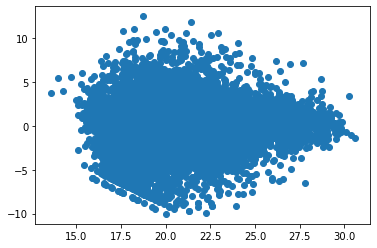

In [404]:
plt.scatter(ypred_series, y_true - ypred_series)

In [403]:
fig.savefig("../Resources/pred_vs_actual.png")

Re-load and test

In [ ]:
test = load("../Models/xgb_basic.pkl")
test